# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные лежат в папке `/datasets/image_search/` или доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

**Загрузим необходимые библиотеки**

In [249]:
pip install torchvision

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [250]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import re
import re
import nltk
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn

from PIL import Image 
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords,wordnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50


In [251]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [252]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [253]:
nltk.download('corpora/wordnet.zip/wordnet/.zip/')

[nltk_data] Error loading corpora/wordnet.zip/wordnet/.zip/: Package
[nltk_data]     'corpora/wordnet.zip/wordnet/.zip/' not found in index


False

**Запишем данные в датафреймы**

In [254]:


pth1 = '/datasets/image_search/train_dataset.csv'
pth2 = '/kaggle/input/sborny4/to_upload/train_dataset.csv'

if os.path.exists(pth1):
    train_df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    train_df = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
    
pth1 = '/datasets/image_search/CrowdAnnotations.tsv'
pth2 = '/kaggle/input/sborny4/to_upload/CrowdAnnotations.tsv'

if os.path.exists(pth1):
    crowd_annot = pd.read_csv(pth1,sep='\t',header=None,
                             names=['image',
                                    'query_id',
                                    'share_crowd_is_true_desc',
                                   'num_is_true_desc',
                                   'num_false_desc'])
elif os.path.exists(pth2):
    crowd_annot = pd.read_csv(pth2,sep='\t',header=None,
                             names=['image',
                                    'query_id',
                                    'share_crowd_is_true_desc',
                                   'num_is_true_desc',
                                   'num_false_desc'])
else:
    print('Something is wrong')
    
    
pth1 = '/datasets/image_search/ExpertAnnotations.tsv'
pth2 = '/kaggle/input/sborny4/to_upload/ExpertAnnotations.tsv'

if os.path.exists(pth1):
    exp_annot = pd.read_csv(pth1,sep='\t',header=None,
                             names=['image',
                                    'query_id',
                                    '1_exp_score',
                                   '2_exp_score',
                                   '3_exp_score'])
elif os.path.exists(pth2):
    exp_annot = pd.read_csv(pth2,sep='\t',header=None,
                             names=['image',
                                    'query_id',
                                    '1_exp_score',
                                   '2_exp_score',
                                   '3_exp_score'])
else:
    print('Something is wrong')
    
    
pth1 = '/datasets/image_search/test_queries.csv'
pth2 = '/kaggle/input/sborny4/to_upload/test_queries.csv'

if os.path.exists(pth1):
    test_query = pd.read_csv(pth1,sep='|')
elif os.path.exists(pth2):
    test_query = pd.read_csv(pth2,sep='|')
else:
    print('Something is wrong')

**Изучим и организуем данные**

In [255]:
display(train_df.head(5))

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                                                 query_text  
0  A young child is wearing blue goggles and sitting in a float in a pool .  
1  A young child is wearing blue goggles and sitting in a float in a pool .  
2  A young child is wearing blue goggles and sitting in a float in a pool .  
3  A young child is wearing blue goggles and sitting in a float in a pool .  
4  A young child is wearing blue goggles and sitting in a float in a pool .

In [256]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


Организация таблицы train_df:
- текст и идентификатор запроса соотнесены с несколькими картинками, причем одна из картинок является идентичной запросу.
- В первом же описании видим признаки, что картинка содержит изображение ребенка. От таких картинок скорее всего придется избавиться в будущем.
- Также в таблице возможны дубликаты.

Проверим данные на дубликаты и посмотрим несколько картинок.

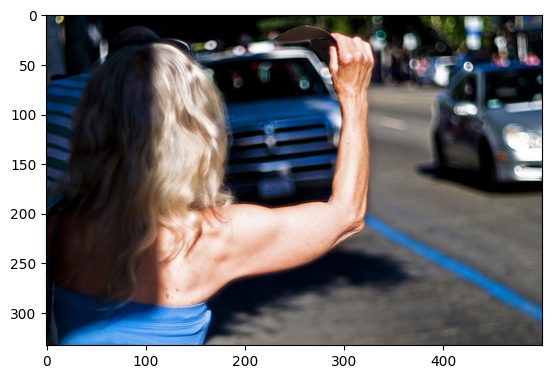

In [257]:
image = Image.open('/kaggle/input/sborny4/to_upload/train_images/1056338697_4f7d7ce270.jpg')
plt.imshow(np.array(image))

In [258]:
train_df.loc[train_df['image'] == '1056338697_4f7d7ce270.jpg']

image                     query_id  \
0   1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
12  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
22  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
27  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
31  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   
38  1056338697_4f7d7ce270.jpg  3360930596_1e75164ce6.jpg#2   
44  1056338697_4f7d7ce270.jpg  3545652636_0746537307.jpg#2   
59  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2   

                                                                                             query_text  
0                              A young child is wearing blue goggles and sitting in a float in a pool .  
12                                                A girl wearing a yellow shirt and sunglasses smiles .  
22                                                      A man sleeps under a blanket on a city street .  
27                                             A woman plays with long red ribbons in an empty square .  
31                                                           Chinese market street in the winter time .  
38      A soccer ball is above the head of a man wearing black shorts and red and black striped shirt .  
44  A young boy dressed in a red uniform kicks the soccer ball on the field as another child in blue...  
59             A man and woman look back at the camera while standing in front of a red art structure .

Очевидно, что ни одно из описаний для картинки в колонке image не соответствует самой картинке.

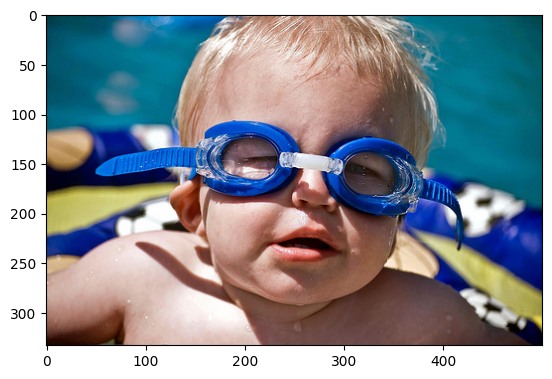

In [259]:
image = Image.open('/kaggle/input/sborny4/to_upload/train_images/2549968784_39bfbe44f9.jpg')
plt.imshow(np.array(image))

In [260]:
train_df.loc[train_df['image'] == '2549968784_39bfbe44f9.jpg']

image                     query_id  \
3     2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4160  2549968784_39bfbe44f9.jpg  2490768374_45d94fc658.jpg#2   
5134  2549968784_39bfbe44f9.jpg  2384353160_f395e9a54b.jpg#2   
5137  2549968784_39bfbe44f9.jpg  3532205154_5674b628ea.jpg#2   

                                                                                               query_text  
3                                A young child is wearing blue goggles and sitting in a float in a pool .  
4160                                                                   a young girl wearing blue smiles .  
5134                                  An older man in a weathered fedora smiles slightly for the camera .  
5137  A man with a shocked expression on his face is holding a beaded necklace that is around a woman ...

Для этой картинки есть соотвествующее описание.

In [261]:
train_df.duplicated().sum()

0

Дубликатов в train_df нет.

In [262]:
crowd_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image                     47830 non-null  object 
 1   query_id                  47830 non-null  object 
 2   share_crowd_is_true_desc  47830 non-null  float64
 3   num_is_true_desc          47830 non-null  int64  
 4   num_false_desc            47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


In [263]:
display(crowd_annot.head(5))

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   

   share_crowd_is_true_desc  num_is_true_desc  num_false_desc  
0                       1.0                 3               0  
1                       0.0                 0               3  
2                       0.0                 0               3  
3                       0.0                 0               3  
4                       0.0                 0               3

In [264]:
crowd_annot.duplicated().sum()

0

В crowd_annot Дубликатов нет.

В таблице crowd_annot для каждой пары картинка-айди описания есть оценки соотвествия описания и картинки от сервиса краудсорсинга. Объеденим эту таблицу с текстом самого поисания по полю desc_id.

In [265]:
final_train_df = pd.merge(crowd_annot, train_df,how='inner', on='query_id')

In [266]:
final_train_df.duplicated().sum()

0

In [267]:
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289862 entries, 0 to 289861
Data columns (total 7 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   image_x                   289862 non-null  object 
 1   query_id                  289862 non-null  object 
 2   share_crowd_is_true_desc  289862 non-null  float64
 3   num_is_true_desc          289862 non-null  int64  
 4   num_false_desc            289862 non-null  int64  
 5   image_y                   289862 non-null  object 
 6   query_text                289862 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 15.5+ MB


Удалим из финального датафрейма колонку image_y, так как модель будет обучаться на данных картинка-описание с целевым признаком, полученным из таблиц краудсорсинга и от экспертов.

In [268]:
final_train_df.drop(columns=['image_y'],inplace=True)

In [269]:
final_train_df.duplicated().sum()

243141

In [270]:
final_train_df.drop_duplicates(inplace=True)

В итоговой таблице обнаружились дубликаты, от которых пришлось избавиться.

In [271]:
final_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46721 entries, 0 to 289857
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image_x                   46721 non-null  object 
 1   query_id                  46721 non-null  object 
 2   share_crowd_is_true_desc  46721 non-null  float64
 3   num_is_true_desc          46721 non-null  int64  
 4   num_false_desc            46721 non-null  int64  
 5   query_text                46721 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 2.5+ MB


In [272]:
final_train_df.head(5)

image_x                     query_id  \
0   1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2   
1   1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2   
9   1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2   
12  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2   
19  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2   

    share_crowd_is_true_desc  num_is_true_desc  num_false_desc  \
0                        1.0                 3               0   
1                        0.0                 0               3   
9                        0.0                 0               3   
12                       0.0                 0               3   
19                       0.0                 0               3   

                                                                            query_text  
0                           A woman is signaling is to traffic , as seen from behind .  
1                                            A boy in glasses is wearing a red shirt .  
9                                     A young boy holds onto a blue handle on a pier .  
12  A woman wearing black clothes , a purple scarf , and a pink hat is riding a bike .  
19                    An older woman with blond hair rides a bicycle down the street .

 Проверим оценки краудсорсинга на адекватность.

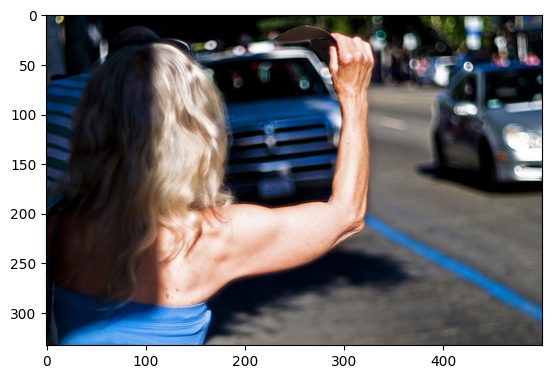

In [273]:
image = Image.open('/kaggle/input/sborny4/to_upload/train_images/1056338697_4f7d7ce270.jpg')
plt.imshow(np.array(image))

Картинка 1056338697_4f7d7ce270.jpg соответствует описанию, краудсорсинг также единогласно высказался за полное соответсвие. Другие картинки с этим же описанием помечены как несоотвтсвуюшие.

Добавим в датасет данные от экспертов.

In [274]:
exp_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image        5822 non-null   object
 1   query_id     5822 non-null   object
 2   1_exp_score  5822 non-null   int64 
 3   2_exp_score  5822 non-null   int64 
 4   3_exp_score  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [275]:
display(exp_annot.head(5))

image                     query_id  1_exp_score  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2            1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2            1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2            1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2            1   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2            1   

   2_exp_score  3_exp_score  
0            1            1  
1            1            2  
2            1            2  
3            2            2  
4            1            2

В таблице exp_annot всего около 6 тысяч строк. Сделаем из поля image и query_id один признак, чтобы объеденить эту таблицу с final_train_df.

In [276]:
exp_annot['id'] = exp_annot['image'].astype(str) + exp_annot['query_id'].astype(str)

In [277]:
final_train_df['id'] = final_train_df['image_x'].astype(str) + final_train_df['query_id'].astype(str)

In [278]:
final_train_df_est = pd.merge(final_train_df,exp_annot, how='inner', on='id')

In [279]:
final_train_df_est.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   image_x                   2329 non-null   object 
 1   query_id_x                2329 non-null   object 
 2   share_crowd_is_true_desc  2329 non-null   float64
 3   num_is_true_desc          2329 non-null   int64  
 4   num_false_desc            2329 non-null   int64  
 5   query_text                2329 non-null   object 
 6   id                        2329 non-null   object 
 7   image                     2329 non-null   object 
 8   query_id_y                2329 non-null   object 
 9   1_exp_score               2329 non-null   int64  
 10  2_exp_score               2329 non-null   int64  
 11  3_exp_score               2329 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 218.5+ KB


объединение обучающего датасета в один выглядит корректно. Удалим ненужные колонки и проверим данные на дубликаты.

In [280]:
final_train_df_est.drop(columns=['image_x','query_id_x'],inplace=True)

In [281]:
final_train_df_est.duplicated().sum()

0

В таблице нет дубликатов.

In [282]:
final_train_df_est.loc[final_train_df_est['image'] == '2549968784_39bfbe44f9.jpg']

share_crowd_is_true_desc  num_is_true_desc  num_false_desc  \
678                       0.0                 0               3   
679                       1.0                 3               0   

                                                                   query_text  \
678                                        a young girl wearing blue smiles .   
679  A young child is wearing blue goggles and sitting in a float in a pool .   

                                                       id  \
678  2549968784_39bfbe44f9.jpg2490768374_45d94fc658.jpg#2   
679  2549968784_39bfbe44f9.jpg2549968784_39bfbe44f9.jpg#2   

                         image                   query_id_y  1_exp_score  \
678  2549968784_39bfbe44f9.jpg  2490768374_45d94fc658.jpg#2            1   
679  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2            4   

     2_exp_score  3_exp_score  
678            1            1  
679            4            4

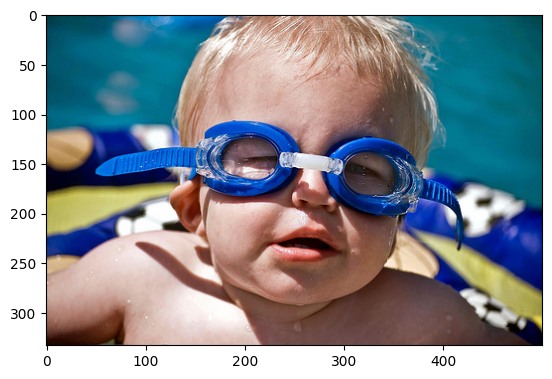

In [283]:
image = Image.open('/kaggle/input/sborny4/to_upload/train_images/2549968784_39bfbe44f9.jpg')
plt.imshow(np.array(image))

Данные выглядят рационально судя по таблице оценок от краудсорсинг и эскпертов, соотнесенных с картинкой.

In [284]:
test_query.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


In [285]:
display(test_query.head(5))

Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                                                                       query_text  \
0  Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .   
1                                               Two boys are squirting water guns at each other .   
2                                                         Two boys spraying each other with water   
3                                         Two children wearing jeans squirt water at each other .   
4                                              Two young boys are squirting water at each other .   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [286]:
test_query.duplicated().sum()

0

В таблице test_query идентифицрована только одна проблема на первый взгляд:
- описание соджержит упоминание детей, что может быть проблемой для использования в тестировании.

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


Агрегируем оценки экспертов по методу усреднения стандартизированных ответов. Стандартизируем оценки по шкале от 0 до 1, чтобы соответсвовали вероятности.

In [287]:
scale_list = ['1_exp_score','2_exp_score','3_exp_score']

In [288]:
scaler = MinMaxScaler()

scaled = scaler.fit_transform(final_train_df_est[scale_list])

names = scaler.get_feature_names_out()

scaled_df = pd.DataFrame(scaled,columns = names)

In [289]:
scaled_df.describe()

1_exp_score  2_exp_score  3_exp_score
count  2329.000000  2329.000000  2329.000000
mean      0.313296     0.400458     0.495062
std       0.327671     0.323491     0.310635
min       0.000000     0.000000     0.000000
25%       0.000000     0.000000     0.333333
50%       0.333333     0.333333     0.333333
75%       0.333333     0.666667     0.666667
max       1.000000     1.000000     1.000000

Масштабирование выглядит корректно.

In [290]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   1_exp_score  2329 non-null   float64
 1   2_exp_score  2329 non-null   float64
 2   3_exp_score  2329 non-null   float64
dtypes: float64(3)
memory usage: 54.7 KB


In [291]:
train_data = final_train_df_est.drop(columns=['1_exp_score','2_exp_score','3_exp_score'])

In [292]:
train_data.reset_index(inplace=True,drop=True)

In [293]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2329 entries, 0 to 2328
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   share_crowd_is_true_desc  2329 non-null   float64
 1   num_is_true_desc          2329 non-null   int64  
 2   num_false_desc            2329 non-null   int64  
 3   query_text                2329 non-null   object 
 4   id                        2329 non-null   object 
 5   image                     2329 non-null   object 
 6   query_id_y                2329 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 127.5+ KB


In [294]:
train_data = pd.concat([train_data,scaled_df],axis=1).reindex(train_data.index)

In [295]:
train_data.head(5)

share_crowd_is_true_desc  num_is_true_desc  num_false_desc  \
0                  0.000000                 0               3   
1                  0.000000                 0               3   
2                  0.000000                 0               3   
3                  0.000000                 0               3   
4                  0.333333                 1               2   

                                                                                 query_text  \
0                  A young child is wearing blue goggles and sitting in a float in a pool .   
1                                     A girl wearing a yellow shirt and sunglasses smiles .   
2  A man and woman look back at the camera while standing in front of a red art structure .   
3                                                     A crowd of people at an outdoor event   
4                                              Close-up of dog in profile with mouth open .   

                                                     id  \
0  1056338697_4f7d7ce270.jpg2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg2718495608_d8533e3ac5.jpg#2   
2   1056338697_4f7d7ce270.jpg434792818_56375e203f.jpg#2   
3  1082379191_ec1e53f996.jpg1536774449_e16b1b6382.jpg#2   
4   1084040636_97d9633581.jpg256085101_2c2617c5d0.jpg#2   

                       image                   query_id_y  1_exp_score  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     0.000000   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     0.000000   
2  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2     0.000000   
3  1082379191_ec1e53f996.jpg  1536774449_e16b1b6382.jpg#2     0.000000   
4  1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2     0.333333   

   2_exp_score  3_exp_score  
0     0.000000     0.000000  
1     0.000000     0.333333  
2     0.000000     0.333333  
3     0.333333     0.666667  
4     0.666667     0.666667

In [296]:
train_data['avg_expert'] = (train_data['1_exp_score']+train_data['2_exp_score']+train_data['3_exp_score'])/3

In [297]:
train_data.head(5)

share_crowd_is_true_desc  num_is_true_desc  num_false_desc  \
0                  0.000000                 0               3   
1                  0.000000                 0               3   
2                  0.000000                 0               3   
3                  0.000000                 0               3   
4                  0.333333                 1               2   

                                                                                 query_text  \
0                  A young child is wearing blue goggles and sitting in a float in a pool .   
1                                     A girl wearing a yellow shirt and sunglasses smiles .   
2  A man and woman look back at the camera while standing in front of a red art structure .   
3                                                     A crowd of people at an outdoor event   
4                                              Close-up of dog in profile with mouth open .   

                                                     id  \
0  1056338697_4f7d7ce270.jpg2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg2718495608_d8533e3ac5.jpg#2   
2   1056338697_4f7d7ce270.jpg434792818_56375e203f.jpg#2   
3  1082379191_ec1e53f996.jpg1536774449_e16b1b6382.jpg#2   
4   1084040636_97d9633581.jpg256085101_2c2617c5d0.jpg#2   

                       image                   query_id_y  1_exp_score  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     0.000000   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     0.000000   
2  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2     0.000000   
3  1082379191_ec1e53f996.jpg  1536774449_e16b1b6382.jpg#2     0.000000   
4  1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2     0.333333   

   2_exp_score  3_exp_score  avg_expert  
0     0.000000     0.000000    0.000000  
1     0.000000     0.333333    0.111111  
2     0.000000     0.333333    0.111111  
3     0.333333     0.666667    0.333333  
4     0.666667     0.666667    0.555556

Оценки экспертов стандартизированы и объеденены в одну оценку. На примере нескольких картинок попробуем понять, по какому приницу усреднять финальную оценку соответствия картинки и описания.

In [298]:
pd.options.display.max_colwidth = 100

In [299]:
train_data.loc[train_data['avg_expert'] > 0.5].head(5)

share_crowd_is_true_desc  num_is_true_desc  num_false_desc  \
4                   0.333333                 1               2   
8                   0.000000                 0               3   
10                  0.000000                 0               3   
11                  0.000000                 0               3   
12                  0.333333                 1               2   

                                                  query_text  \
4               Close-up of dog in profile with mouth open .   
8           Large dog plays with two smaller dogs on grass .   
10                       Three dogs are playing in a field .   
11                              A dog rolling in the grass .   
12  A small brown and white dog running through tall grass .   

                                                      id  \
4    1084040636_97d9633581.jpg256085101_2c2617c5d0.jpg#2   
8   1107246521_d16a476380.jpg2410320522_d967f0b75c.jpg#2   
10  1107246521_d16a476380.jpg3582742297_1daa29968e.jpg#2   
11   1119015538_e8e796281e.jpg229862312_1a0ba19dab.jpg#2   
12  1119015538_e8e796281e.jpg2534502836_7a75305655.jpg#2   

                        image                   query_id_y  1_exp_score  \
4   1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2     0.333333   
8   1107246521_d16a476380.jpg  2410320522_d967f0b75c.jpg#2     0.333333   
10  1107246521_d16a476380.jpg  3582742297_1daa29968e.jpg#2     0.666667   
11  1119015538_e8e796281e.jpg   229862312_1a0ba19dab.jpg#2     0.666667   
12  1119015538_e8e796281e.jpg  2534502836_7a75305655.jpg#2     0.333333   

    2_exp_score  3_exp_score  avg_expert  
4      0.666667     0.666667    0.555556  
8      0.666667     0.666667    0.555556  
10     0.666667     0.666667    0.666667  
11     0.666667     0.666667    0.666667  
12     0.666667     1.000000    0.666667

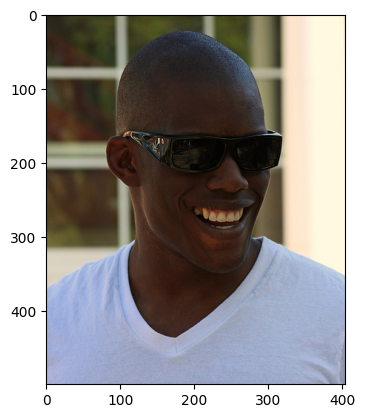

In [300]:
image = Image.open('/kaggle/input/sborny4/to_upload/train_images/3503689049_63212220be.jpg')
plt.imshow(np.array(image))

По данным экспертов, картинка выше на 66% соответствует описанию (по новому агрегированному параметру). Формулировка соответствия от экспертов - "запрос и текст соответствуют с точностью до некоторых деталей".
По описанию на картинке должен быть улабыщийся мужчина в черной футболке и кепке, но по факту изображен улыбающийся мужчина в белой футболке и без кепки. Вероятность соотвествия картинки и описания от краудсорсинга равна нулю, что неправдаподобно.

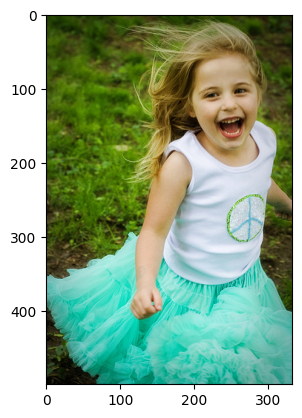

In [301]:
image = Image.open('/kaggle/input/sborny4/to_upload/train_images/2490768374_45d94fc658.jpg')
plt.imshow(np.array(image))

По данной картинке и у экспертов и у краудсорсинга одинаковая вероятность соответствия 67%. На картинке изображена улыбающаяся девочка в бирюзовом платье, а описание подразумевает "юнаю девочку с голубыми улыбками" (явно написано с смысловыми ошибками). В целом описание соотвествует картинке, поэтому обе оценки правдоподобны.

In [302]:
train_data.loc[(train_data['avg_expert'] < 0.5) & 
              (train_data['share_crowd_is_true_desc'] > 0.5)].head(5)

share_crowd_is_true_desc  num_is_true_desc  num_false_desc  \
22                   0.666667                 2               1   
137                  0.666667                 2               1   
237                  0.666667                 2               1   
253                  0.666667                 2               1   
383                  0.666667                 2               1   

                                                   query_text  \
22                  Four people climbing a hill in the snow .   
137                     A crowd of people at an outdoor event   
237  Many bundled up people are standing in a public square .   
253                     A crowd of people at an outdoor event   
383                  A mountain skier heads down a mountain .   

                                                       id  \
22    115684808_cb01227802.jpg1472882567_33dc14c8b6.jpg#2   
137  1461667284_041c8a2475.jpg1536774449_e16b1b6382.jpg#2   
237  1962729184_6996e128e7.jpg3245912109_fdeef6b456.jpg#2   
253   200771289_31902164a7.jpg1536774449_e16b1b6382.jpg#2   
383   223299142_521aedf9e7.jpg3364026240_645d533fda.jpg#2   

                         image                   query_id_y  1_exp_score  \
22    115684808_cb01227802.jpg  1472882567_33dc14c8b6.jpg#2     0.333333   
137  1461667284_041c8a2475.jpg  1536774449_e16b1b6382.jpg#2     0.333333   
237  1962729184_6996e128e7.jpg  3245912109_fdeef6b456.jpg#2     0.000000   
253   200771289_31902164a7.jpg  1536774449_e16b1b6382.jpg#2     0.333333   
383   223299142_521aedf9e7.jpg  3364026240_645d533fda.jpg#2     0.333333   

     2_exp_score  3_exp_score  avg_expert  
22      0.333333     0.666667    0.444444  
137     0.333333     0.666667    0.444444  
237     0.333333     0.666667    0.333333  
253     0.333333     0.666667    0.444444  
383     0.333333     0.666667    0.444444

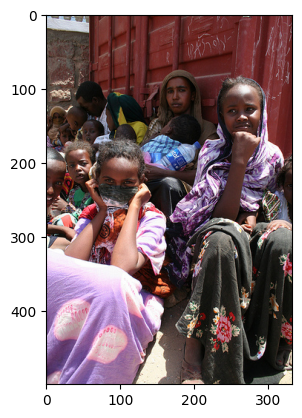

In [303]:
image = Image.open('/kaggle/input/sborny4/to_upload/train_images/3350786891_6d39b234e9.jpg')
plt.imshow(np.array(image))

На картинке изображена группа людей с темным цветом кожи на улице либо в трущобах, либо в каком-то логистическом пункте (на фоне видны контейнеры). По одежде люди выглядат как принадлежащие к невысокому социальному классу. Описание следующее: "толпа людей на мероприятии на свежем воздухе". 

По оценке экспертов картинка на 44% соотвествует описанию, подчеркивая, что лишь отдельные элементы картинки соответствуют запросу. По оценке краудсорсинга картинка на 100% соответствует описанию - это неправдоподобно.

**Вывод по анализу итоговой агрегации оценок**

Как видно на примере 3 картинок выше, оценки экспертов и краудсорсинга либо совпадают и соотвествуют правде, либо оценки экспертов лучше отражают действительность. Поэтому, для итоговой оценки соответсвия картинки и описания сделаем комбинированную метрика, на 80% соответствующую оценке экспертов и на 20% - оценке краудсорсинга.

In [304]:
train_data['score'] = 0.8 * train_data['avg_expert'] + 0.2 * train_data['share_crowd_is_true_desc']

In [305]:
train_data.drop(columns=['1_exp_score','2_exp_score','3_exp_score','avg_expert',
                        'share_crowd_is_true_desc','num_is_true_desc','num_false_desc'],inplace=True)

In [306]:
train_data.head(5)

query_text  \
0                  A young child is wearing blue goggles and sitting in a float in a pool .   
1                                     A girl wearing a yellow shirt and sunglasses smiles .   
2  A man and woman look back at the camera while standing in front of a red art structure .   
3                                                     A crowd of people at an outdoor event   
4                                              Close-up of dog in profile with mouth open .   

                                                     id  \
0  1056338697_4f7d7ce270.jpg2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg2718495608_d8533e3ac5.jpg#2   
2   1056338697_4f7d7ce270.jpg434792818_56375e203f.jpg#2   
3  1082379191_ec1e53f996.jpg1536774449_e16b1b6382.jpg#2   
4   1084040636_97d9633581.jpg256085101_2c2617c5d0.jpg#2   

                       image                   query_id_y     score  
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  0.000000  
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  0.088889  
2  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2  0.088889  
3  1082379191_ec1e53f996.jpg  1536774449_e16b1b6382.jpg#2  0.266667  
4  1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2  0.511111

In [307]:
train_data['score'].describe()

count    2329.000000
mean        0.362008
std         0.302038
min         0.000000
25%         0.088889
50%         0.266667
75%         0.533333
max         1.000000
Name: score, dtype: float64

**Вывод** 

Оценки агрегированы в одну метрику score, которая имеет значения от нуля до единицы.

## 2. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

---

Проведем токенезацию и лемматизацию описаний - это поможет составить список запрещенных слов и будет использовано в дальнейшем в модели.

In [308]:
train_data['query_text'] = train_data['query_text'].str.lower()

In [309]:
corpus = list(train_data['query_text'].values)

In [310]:
def lemmatize(text):
    m = Mystem()
    lem = m.lemmatize(text)
    return ''.join(lem)

In [311]:
def nltk_pos_tagger(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None

In [312]:
def lemmatize(texts):
    m = WordNetLemmatizer()
    lemm_texts = []
    for text in texts:
        nltk_tagged = nltk.pos_tag(nltk.word_tokenize(text))  
        wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
        lemmatized_sentence = []
    
        for word, tag in wordnet_tagged:
            if tag is None:
                lemmatized_sentence.append(word)
            else:        
                lemmatized_sentence.append(m.lemmatize(word, tag))
        
        lemmatized_sentence = " ".join(lemmatized_sentence).replace('\n', '').strip()
        lemm_texts.append(lemmatized_sentence)
        
    return lemm_texts

Также очистим текст от точек и запятых.

In [313]:
def clear_text(texts):
    clean_texts = []
    for text in texts:
        clean_text = re.sub(r'(\,)|(\.)',
                            ' ',
                            str(text))
        clean_text = clean_text.split()
        clean_text = ' '.join(clean_text)
        clean_texts.append(clean_text)
    return clean_texts

In [314]:
clean_text = clear_text(corpus)

In [315]:

from nltk import wsd
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import wordnet as wn
from spacy.cli import download
from spacy import load
import warnings

nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('wordnet2022')
nlp = load('en_core_web_sm')

! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet # temp fix for lookup error.


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to /usr/share/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [316]:
corpus_lemm = lemmatize(clean_text)

In [317]:
corpus_lemm

['a young child be wear blue goggles and sit in a float in a pool',
 'a girl wear a yellow shirt and sunglass smile',
 'a man and woman look back at the camera while stand in front of a red art structure',
 'a crowd of people at an outdoor event',
 'close-up of dog in profile with mouth open',
 'a dog get on a trampoline',
 'a white dog jump to catch a blue ball in a living room',
 'a young boy kick a soccer ball while six others play but be dress as referee',
 'large dog play with two small dog on grass',
 'two beige dog be play in the grass near a doghouse',
 'three dog be play in a field',
 'a dog roll in the grass',
 'a small brown and white dog run through tall grass',
 'a white dog run in the grass',
 'the football player wear a white helmet and orange chair swing his leg while the player next to him kneel',
 'four woman wear formal gown pose together and smile',
 'two men and a woman smile at the camera',
 'a brown dog shake off water',
 'brown and white dog jumping over a low r

Составим список уникальных слов-существительных из предложений в описаниях.

In [318]:
def unique_nouns(sentences):
    # Tokenize each sentence into words, perform part-of-speech tagging, and filter out unique nouns
    unique_nouns = set()
    for sentence in sentences:
        words = nltk.word_tokenize(sentence)
        tagged_words = nltk.pos_tag(words)
        unique_nouns.update(word for word, pos in tagged_words if pos.startswith('N'))
    
    return list(unique_nouns)



In [319]:

unique_nouns_list = unique_nouns(corpus_lemm)


In [320]:
print(unique_nouns_list)

['spot', 'cricketer', 'scooter', 'outside', 'mardi', 'tattoo', 'nail', 'life', 'toy', 'photo', 'paddling', 'bend', 'braid', 'hulahoop', 'knit', 'chocolate', 'student', 'fence', 'music', 'backwards', 'onlooker', 'windsurfs', 'left', 'blonde', 'piste', 'jet', 'field', 'sooner', 'officer', 'seaworld', 'middle', 'ready', 'sign', 'peek', 'produce', 'railing', 'snowball', 'blue', 'handlebar', 'musician', 'suv', 'literature', 'bear', 'corner', 'base', 'parking', 'cut', 'backpack', 'barrier', 'lake', 'member', 'road', 'fireplace', 'street', 'kitten', 'kitchen', 'stroller', 'ivars', 'shoreline', 'bench', 'wading', 'block', 'wear', 'face', 'pirate', 'surround', 'vehicle', 'ridge', 'rag', 'runner', 'skier', 'suit', 'step', 'catch', 'motorbike', 'stunt', 'board', 'stage', 'clothes', 'snack', 'half-smile', 'forest', 'track', 'playing', 'tire', 'race', 'follow', 'squirt', 'lady', 'glass', 'theme', 'hardwood', 'cigarette', 'tongue', 'lip', 'whip', 'talk', 'leg', 'motocross', 'chip', 'trail', 'leash',

Составим список запрещенных слов.

In [321]:
restricted_words = ['baby','boy','girl','kid','teenage','toddler']

Добавим лемматизированный текст в обучающий датафрейм, а затем удалим строки, содержащие запрещенные слова в описании. 

In [322]:
corp_df = pd.DataFrame(corpus_lemm,columns=['lemm_desc'])

In [323]:
train_data['lemm_query'] = corp_df['lemm_desc']

In [324]:
train_data.head(5)

query_text  \
0                  a young child is wearing blue goggles and sitting in a float in a pool .   
1                                     a girl wearing a yellow shirt and sunglasses smiles .   
2  a man and woman look back at the camera while standing in front of a red art structure .   
3                                                     a crowd of people at an outdoor event   
4                                              close-up of dog in profile with mouth open .   

                                                     id  \
0  1056338697_4f7d7ce270.jpg2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg2718495608_d8533e3ac5.jpg#2   
2   1056338697_4f7d7ce270.jpg434792818_56375e203f.jpg#2   
3  1082379191_ec1e53f996.jpg1536774449_e16b1b6382.jpg#2   
4   1084040636_97d9633581.jpg256085101_2c2617c5d0.jpg#2   

                       image                   query_id_y     score  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  0.000000   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2  0.088889   
2  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2  0.088889   
3  1082379191_ec1e53f996.jpg  1536774449_e16b1b6382.jpg#2  0.266667   
4  1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2  0.511111   

                                                                            lemm_query  
0                      a young child be wear blue goggles and sit in a float in a pool  
1                                        a girl wear a yellow shirt and sunglass smile  
2  a man and woman look back at the camera while stand in front of a red art structure  
3                                                a crowd of people at an outdoor event  
4                                           close-up of dog in profile with mouth open

In [325]:
mask = train_data['lemm_query'].str.contains('|'.join(restricted_words), case=False)

inverted_mask = ~mask

filtered_train_data = train_data[inverted_mask]

In [326]:
filtered_train_data.head(5)

query_text  \
0                  a young child is wearing blue goggles and sitting in a float in a pool .   
2  a man and woman look back at the camera while standing in front of a red art structure .   
3                                                     a crowd of people at an outdoor event   
4                                              close-up of dog in profile with mouth open .   
5                                                              a dog gets on a trampoline .   

                                                     id  \
0  1056338697_4f7d7ce270.jpg2549968784_39bfbe44f9.jpg#2   
2   1056338697_4f7d7ce270.jpg434792818_56375e203f.jpg#2   
3  1082379191_ec1e53f996.jpg1536774449_e16b1b6382.jpg#2   
4   1084040636_97d9633581.jpg256085101_2c2617c5d0.jpg#2   
5  1084040636_97d9633581.jpg3396157719_6807d52a81.jpg#2   

                       image                   query_id_y     score  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  0.000000   
2  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2  0.088889   
3  1082379191_ec1e53f996.jpg  1536774449_e16b1b6382.jpg#2  0.266667   
4  1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2  0.511111   
5  1084040636_97d9633581.jpg  3396157719_6807d52a81.jpg#2  0.177778   

                                                                            lemm_query  
0                      a young child be wear blue goggles and sit in a float in a pool  
2  a man and woman look back at the camera while stand in front of a red art structure  
3                                                a crowd of people at an outdoor event  
4                                           close-up of dog in profile with mouth open  
5                                                            a dog get on a trampoline

In [327]:
filtered_train_data.reset_index(inplace=True,drop=True)

**Вывод**

Описания были токенезированы и лематизированы. Затем был получен список уникальных существительных из всех описаний и подготовлен список запрщенных слов с упоминанием детей. После этого из обучаещего датафрема были удалены строки с упоминанием запрещенных слов в описании.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [328]:
resnet18 = models.resnet18(pretrained=True)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [329]:
for param in resnet18.parameters():
    param.requires_grad_(False) 

In [330]:
modules = list(resnet18.children())[:-2]
resnet18 = nn.Sequential(*modules) 

In [331]:
resnet18.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [332]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
]) 

In [333]:
image_path = '/kaggle/input/sborny4/to_upload/train_images/3350786891_6d39b234e9.jpg'

In [334]:
image = Image.open(image_path).convert('RGB')


In [335]:
image_tensor = preprocess(image)


In [336]:
output_tensor = resnet18(image_tensor.unsqueeze(0)).flatten()

In [337]:
print(output_tensor)

tensor([0.0000, 0.0000, 0.0000,  ..., 0.7283, 0.0000, 0.0000])


In [338]:
# Path to the folder containing images
folder_path = '/kaggle/input/sborny4/to_upload/train_images/'

# List all files in the folder
image_files = os.listdir(folder_path)

# Initialize lists to store image names and tensors
image_names = []
image_tensors = []

In [339]:

# Loop through each image file in the folder
for image_file in image_files:
    # Read the image
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path).convert('RGB')
    
    # Preprocess the image
    image_tensor = preprocess(image)
    
    # Extract features using ResNet-18
    output_tensor = resnet18(image_tensor.unsqueeze(0)).flatten()
    image_array = output_tensor.detach().numpy()
    
    # Append image name and tensor to lists
    image_names.append(image_file)
    image_tensors.append(image_array)

# Create a DataFrame from the lists
image_vector_train = pd.DataFrame({'image': image_names, 'Image_Tensor': image_tensors})

In [340]:
display(image_vector_train.head(5))

image  \
0   280706862_14c30d734a.jpg   
1   929679367_ff8c7df2ee.jpg   
2  1317292658_ba29330a0b.jpg   
3  3411393875_a9ff73c67a.jpg   
4  3619416477_9d18580a14.jpg   

                                                                                          Image_Tensor  
0  [0.024235956, 0.0, 0.13123377, 0.0, 0.0, 0.0, 0.0, 0.33826476, 0.48194, 0.6845563, 0.0, 0.0, 0.0...  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3375966, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.19...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.8215414, 0.0, 0.0, 0.0, 0.0,...  
3  [0.0, 0.0, 0.0, 0.07217216, 1.1070291, 1.5548887, 0.8531122, 0.0, 0.0, 0.0, 0.2246498, 1.6089722...  
4  [0.0, 0.0, 0.0, 0.0, 1.322086, 3.105196, 4.1773176, 0.0, 0.0, 0.0, 0.0, 1.3921443, 3.2051501, 4....

In [341]:
image_vector_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   image         1000 non-null   object
 1   Image_Tensor  1000 non-null   object
dtypes: object(2)
memory usage: 15.8+ KB


Векторизовали картинки для обучения.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [342]:
nltk.download('stopwords') 
stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [343]:
count_vect = CountVectorizer(stop_words=list(stop_words))


In [344]:
filtered_train_data.columns

Index(['query_text', 'id', 'image', 'query_id_y', 'score', 'lemm_query'], dtype='object')

In [345]:
filtered_train_data['lemm_query'].head(5)

0                        a young child be wear blue goggles and sit in a float in a pool
1    a man and woman look back at the camera while stand in front of a red art structure
2                                                  a crowd of people at an outdoor event
3                                             close-up of dog in profile with mouth open
4                                                              a dog get on a trampoline
Name: lemm_query, dtype: object

In [346]:
n_gramm = count_vect.fit_transform(filtered_train_data['lemm_query'])

In [347]:
n_gramm.shape

(1883, 826)

In [348]:
n_gr_array = n_gramm.toarray()

In [349]:
n_gr_array

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [350]:
text_train = pd.DataFrame(np.arange(0,1883).reshape(1883,1))

In [351]:
text_train['text_train'] = n_gr_array.tolist()

In [352]:
text_train.drop(columns=[0],inplace=True)

In [353]:
display(text_train.head(5))

text_train
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...

Предварительно лемматизированные тексты были векторизованы.

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [354]:
train_vector_df= pd.concat([filtered_train_data,text_train],axis=1)

In [355]:
train_vector_df = pd.merge(train_vector_df,image_vector_train, how='inner', on='image')

In [356]:
display(train_vector_df.head(5))

query_text  \
0                  a young child is wearing blue goggles and sitting in a float in a pool .   
1  a man and woman look back at the camera while standing in front of a red art structure .   
2                                                     a crowd of people at an outdoor event   
3                                              close-up of dog in profile with mouth open .   
4                                                              a dog gets on a trampoline .   

                                                     id  \
0  1056338697_4f7d7ce270.jpg2549968784_39bfbe44f9.jpg#2   
1   1056338697_4f7d7ce270.jpg434792818_56375e203f.jpg#2   
2  1082379191_ec1e53f996.jpg1536774449_e16b1b6382.jpg#2   
3   1084040636_97d9633581.jpg256085101_2c2617c5d0.jpg#2   
4  1084040636_97d9633581.jpg3396157719_6807d52a81.jpg#2   

                       image                   query_id_y     score  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2  0.000000   
1  1056338697_4f7d7ce270.jpg   434792818_56375e203f.jpg#2  0.088889   
2  1082379191_ec1e53f996.jpg  1536774449_e16b1b6382.jpg#2  0.266667   
3  1084040636_97d9633581.jpg   256085101_2c2617c5d0.jpg#2  0.511111   
4  1084040636_97d9633581.jpg  3396157719_6807d52a81.jpg#2  0.177778   

                                                                            lemm_query  \
0                      a young child be wear blue goggles and sit in a float in a pool   
1  a man and woman look back at the camera while stand in front of a red art structure   
2                                                a crowd of people at an outdoor event   
3                                           close-up of dog in profile with mouth open   
4                                                            a dog get on a trampoline   

                                                                                            text_train  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                                                          Image_Tensor  
0  [1.4565353, 1.4629921, 0.0037892463, 0.0, 0.0, 0.0, 0.0, 2.0004408, 2.5717585, 2.1296592, 1.3290...  
1  [1.4565353, 1.4629921, 0.0037892463, 0.0, 0.0, 0.0, 0.0, 2.0004408, 2.5717585, 2.1296592, 1.3290...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5892371, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5137892, 0.0, 0.0, 0.0...  
3  [0.0, 0.0, 0.0, 0.09784315, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  
4  [0.0, 0.0, 0.0, 0.09784315, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...

In [357]:
train_vector_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   query_text    1883 non-null   object 
 1   id            1883 non-null   object 
 2   image         1883 non-null   object 
 3   query_id_y    1883 non-null   object 
 4   score         1883 non-null   float64
 5   lemm_query    1883 non-null   object 
 6   text_train    1883 non-null   object 
 7   Image_Tensor  1883 non-null   object 
dtypes: float64(1), object(7)
memory usage: 117.8+ KB


In [358]:
train_vector_df.columns

Index(['query_text', 'id', 'image', 'query_id_y', 'score', 'lemm_query',
       'text_train', 'Image_Tensor'],
      dtype='object')

In [359]:
train_vector_df.drop(columns=['query_text', 'id', 'query_id_y', 'lemm_query'],inplace=True)

In [360]:
train_vector_df.head(5)

image     score  \
0  1056338697_4f7d7ce270.jpg  0.000000   
1  1056338697_4f7d7ce270.jpg  0.088889   
2  1082379191_ec1e53f996.jpg  0.266667   
3  1084040636_97d9633581.jpg  0.511111   
4  1084040636_97d9633581.jpg  0.177778   

                                                                                            text_train  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                                                          Image_Tensor  
0  [1.4565353, 1.4629921, 0.0037892463, 0.0, 0.0, 0.0, 0.0, 2.0004408, 2.5717585, 2.1296592, 1.3290...  
1  [1.4565353, 1.4629921, 0.0037892463, 0.0, 0.0, 0.0, 0.0, 2.0004408, 2.5717585, 2.1296592, 1.3290...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5892371, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5137892, 0.0, 0.0, 0.0...  
3  [0.0, 0.0, 0.0, 0.09784315, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...  
4  [0.0, 0.0, 0.0, 0.09784315, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...

In [361]:
train_vector_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1883 entries, 0 to 1882
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   image         1883 non-null   object 
 1   score         1883 non-null   float64
 2   text_train    1883 non-null   object 
 3   Image_Tensor  1883 non-null   object 
dtypes: float64(1), object(3)
memory usage: 59.0+ KB


Для обучения модели подготовлен датафрейм с 5,649 векторизованныйми картинками, текстами и оценками соответсвия.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

In [362]:
from sklearn.model_selection import GroupShuffleSplit

In [363]:
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)

In [364]:
train_indices, test_indices = next(gss.split(X=train_vector_df.drop(columns=['image','score']), 
                                             y=train_vector_df['score'], 
                                             groups=train_vector_df['image']))

In [365]:
train_df, test_df = train_vector_df.loc[train_indices], train_vector_df.loc[test_indices]

In [366]:
train_df.drop(columns=['image'],inplace=True)
test_df.drop(columns=['image'],inplace=True)

In [367]:
train_df.head(5)

score  \
0  0.000000   
1  0.088889   
2  0.266667   
5  0.266667   
6  0.444444   

                                                                                            text_train  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
5  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
6  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                                                                          Image_Tensor  
0  [1.4565353, 1.4629921, 0.0037892463, 0.0, 0.0, 0.0, 0.0, 2.0004408, 2.5717585, 2.1296592, 1.3290...  
1  [1.4565353, 1.4629921, 0.0037892463, 0.0, 0.0, 0.0, 0.0, 2.0004408, 2.5717585, 2.1296592, 1.3290...  
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5892371, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5137892, 0.0, 0.0, 0.0...  
5  [1.2144517, 1.4655515, 1.4591751, 0.25640124, 0.0, 0.0, 0.0, 2.0867481, 5.339117, 6.691864, 5.84...  
6  [0.0, 0.0, 0.0, 1.0358347, 2.5238364, 2.7791722, 1.5877594, 0.0, 0.0, 1.1790476, 2.9903438, 3.51...

In [368]:
text_train_tensor = torch.tensor(train_df['text_train'].tolist())
Image_Tensor = torch.tensor(train_df['Image_Tensor'].tolist())

# Concatenate tensors along dimension 1 (columns)
train_x = torch.cat((text_train_tensor, Image_Tensor), dim=1).numpy()



In [369]:
print(train_x)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [370]:
train_y = train_df['score']

In [371]:
text_train_tensor = torch.tensor(test_df['text_train'].tolist())
Image_Tensor = torch.tensor(test_df['Image_Tensor'].tolist())

# Concatenate tensors along dimension 1 (columns)
test_x = torch.cat((text_train_tensor, Image_Tensor), dim=1).numpy()

In [372]:
print(test_x)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.81596303 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 2.5980947  1.851995   1.6598408 ]]


In [373]:
test_y = test_df['score']

Данные разделены на обучающую и тестовую выборки - попробуем применить несколько моделей для предсказания оценки соответствия. Так как перед нами задача регрессии - выберем в качестве метрики MSE.

**Линейная регрессия**

In [374]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [375]:
# Create linear regression model
model = LinearRegression()

# Train the model
model.fit(train_x, train_y)

# Make predictions on the test set
predictions = model.predict(test_x)

# Evaluate the model
mse = mean_squared_error(test_y, predictions)
rmse = np.sqrt(mse)
print("Mean Squared Error:", rmse)

# Coefficients and intercept
print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

Mean Squared Error: 2924.9144512234907
Coefficients: [ -99.30095   -243.58333   -278.2603    ...   -7.7241025   -0.5279391
    4.361666 ]
Intercept: 1528.4418


Линейная регрессия совершенно не справляется с данной задачей - RMSE около 3 тычяч. Попробуем применить моделиь нейронной сети.

**Нейронная сеть**

In [376]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

In [377]:

X_train_tensor = torch.tensor(train_x, dtype=torch.float32)
y_train_tensor = torch.tensor(train_y.values, dtype=torch.float32)
X_test_tensor = torch.tensor(test_x, dtype=torch.float32)
y_test_tensor = torch.tensor(test_y.values, dtype=torch.float32)

In [378]:
class FullyConnectedNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layers):
        super(FullyConnectedNN, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_size, output_size))
        layers.append(nn.Sigmoid())  # Apply sigmoid activation function
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [379]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [380]:


# Define hyperparameters
input_size = train_x.shape[1]  # Number of features
hidden_size = 100  # Number of neurons in the hidden layer
output_size = 1  # Number of output units (since it's a regression problem)
num_hidden_layers = 3 

In [381]:
# Initialize the model
model = FullyConnectedNN(input_size, hidden_size, output_size, num_hidden_layers)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error loss
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer

In [382]:
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs.squeeze(), y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0812
Epoch [20/100], Loss: 0.0648
Epoch [30/100], Loss: 0.0504
Epoch [40/100], Loss: 0.0451
Epoch [50/100], Loss: 0.0428
Epoch [60/100], Loss: 0.0419
Epoch [70/100], Loss: 0.0402
Epoch [80/100], Loss: 0.0397
Epoch [90/100], Loss: 0.0394
Epoch [100/100], Loss: 0.0394


In [383]:
# Evaluate the model
with torch.no_grad():
    model.eval()
    outputs = model(X_test_tensor)
    rmse = torch.sqrt(criterion(outputs.squeeze(), y_test_tensor)).item()
    print(f'RMSE on test set: {rmse:.4f}')

RMSE on test set: 0.3169


Метрика RMSE для нейронной сети получилась около 30%, что значительно лучше результата регрессии. Далее проверим модель на тестовых данных.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

Загрузим Датафрейм с названиями картинок для теста.

In [384]:
pth1 = '/datasets/image_search/train_dataset.csv'
pth2 = '/kaggle/input/sborny4/to_upload/test_images.csv'

if os.path.exists(pth1):
    test_images = pd.read_csv(pth1)
elif os.path.exists(pth2):
    test_images = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [385]:
display(test_images.head(5))

image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [386]:
test_images.shape

(100, 1)

Получим эмбединги картинок.

In [387]:
# Path to the folder containing images
folder_path = '/kaggle/input/sborny4/to_upload/test_images'

# List all files in the folder
image_files = os.listdir(folder_path)

# Initialize lists to store image names and tensors
image_names = []
image_tensors = []

In [388]:

# Loop through each image file in the folder
for image_file in image_files:
    # Read the image
    image_path = os.path.join(folder_path, image_file)
    image = Image.open(image_path).convert('RGB')
    
    # Preprocess the image
    image_tensor = preprocess(image)
    
    # Extract features using ResNet-18
    output_tensor = resnet18(image_tensor.unsqueeze(0)).flatten()
    image_array = output_tensor.detach().numpy()
    
    # Append image name and tensor to lists
    image_names.append(image_file)
    image_tensors.append(image_array)

# Create a DataFrame from the lists
test_image_vector = pd.DataFrame({'image': image_names, 'Image_Tensor': image_tensors})

In [389]:
display(test_image_vector.head(5))

image  \
0  1319634306_816f21677f.jpg   
1  3163198309_bbfe504f0a.jpg   
2  2308256827_3c0a7d514d.jpg   
3  3119913014_688d4997d7.jpg   
4  3555573680_41c1540a86.jpg   

                                                                                          Image_Tensor  
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.13607666, 0.90734303, 1.8695611, 1.4236978, 0.14927694, 0.0, 0....  
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2106097, 1.7059989, 1.2...  
2  [1.7102188, 2.718932, 3.431103, 4.1406765, 3.655019, 1.743474, 0.09278782, 0.70403874, 1.8974319...  
3  [1.9803207, 0.74607664, 0.0, 0.0, 0.0, 0.0, 0.0, 4.7755404, 4.6121078, 3.35526, 1.2575576, 0.994...  
4  [1.080673, 1.6197143, 2.5096693, 1.8704462, 1.2650098, 0.29987884, 0.28208894, 1.7141823, 2.5089...

In [390]:
test_image_vector.shape[0]

100

In [391]:
display(test_query.head(20))

Unnamed: 0                     query_id  \
0            0  1177994172_10d143cb8d.jpg#0   
1            1  1177994172_10d143cb8d.jpg#1   
2            2  1177994172_10d143cb8d.jpg#2   
3            3  1177994172_10d143cb8d.jpg#3   
4            4  1177994172_10d143cb8d.jpg#4   
5            5  1232148178_4f45cc3284.jpg#0   
6            6  1232148178_4f45cc3284.jpg#1   
7            7  1232148178_4f45cc3284.jpg#2   
8            8  1232148178_4f45cc3284.jpg#3   
9            9  1232148178_4f45cc3284.jpg#4   
10          10   123997871_6a9ca987b1.jpg#0   
11          11   123997871_6a9ca987b1.jpg#1   
12          12   123997871_6a9ca987b1.jpg#2   
13          13   123997871_6a9ca987b1.jpg#3   
14          14   123997871_6a9ca987b1.jpg#4   
15          15  1319634306_816f21677f.jpg#0   
16          16  1319634306_816f21677f.jpg#1   
17          17  1319634306_816f21677f.jpg#2   
18          18  1319634306_816f21677f.jpg#3   
19          19  1319634306_816f21677f.jpg#4   

                                                                                             query_text  \
0        Two blonde boys , one in a camouflage shirt and the other in blue , are having a water fight .   
1                                                     Two boys are squirting water guns at each other .   
2                                                               Two boys spraying each other with water   
3                                               Two children wearing jeans squirt water at each other .   
4                                                    Two young boys are squirting water at each other .   
5                                                                       A baby girl playing at a park .   
6                                         A closeup of a child on a playground with adult supervision .   
7                                            A young boy poses for a picture in front of a playground .   
8                                            A young girl is smiling in front of the camera at a park .   
9   There is a little blond hair girl with a green sweatshirt and a red shirt playing on a playground .   
10                                                   Girls wearing sports uniforms and eye protection .   
11                                             Several female lacrosse players are going after a ball .   
12                                           These girls are in uniforms and are playing field hockey .   
13                                       The woman lacrosse player in blue is about to catch the ball .   
14                                                                                Women play lacrosse .   
15                                                          A brown dog is sitting in some long grass .   
16                                                               A brown dog sits still on a hillside .   
17                                                              A large tan dog sits on a grassy hill .   
18                                                            A large yellow dog is sitting on a hill .   
19                                                         The dog is sitting on the side of the hill .   

                        image  
0   1177994172_10d143cb8d.jpg  
1   1177994172_10d143cb8d.jpg  
2   1177994172_10d143cb8d.jpg  
3   1177994172_10d143cb8d.jpg  
4   1177994172_10d143cb8d.jpg  
5   1232148178_4f45cc3284.jpg  
6   1232148178_4f45cc3284.jpg  
7   1232148178_4f45cc3284.jpg  
8   1232148178_4f45cc3284.jpg  
9   1232148178_4f45cc3284.jpg  
10   123997871_6a9ca987b1.jpg  
11   123997871_6a9ca987b1.jpg  
12   123997871_6a9ca987b1.jpg  
13   123997871_6a9ca987b1.jpg  
14   123997871_6a9ca987b1.jpg  
15  1319634306_816f21677f.jpg  
16  1319634306_816f21677f.jpg  
17  1319634306_816f21677f.jpg  
18  1319634306_816f21677f.jpg  
19  1319634306_816f21677f.jpg

In [392]:
def clear_query(query):


    clean_text = re.sub(r'(\,)|(\.)',
                            ' ',
                        str(query))
    clean_text = clean_text.split()
    clean_text = ' '.join(clean_text)

    return clean_text

In [393]:
def lemmatize_query(query):
    m = WordNetLemmatizer()
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(query))  
    wordnet_tagged = map(lambda x: (x[0], nltk_pos_tagger(x[1])), nltk_tagged)
    lemmatized_sentence = []
    
    for word, tag in wordnet_tagged:
        if tag is None:
            lemmatized_sentence.append(word)
        else:        
            lemmatized_sentence.append(m.lemmatize(word, tag))
        
    lemmatized_sentence = " ".join(lemmatized_sentence).replace('\n', '').strip()
        
    return lemmatized_sentence

In [394]:
test_image_path = '/kaggle/input/sborny4/to_upload/test_images/'

In [395]:
def test_model(n):

    lemm = lemmatize_query(clear_query(test_query['query_text'].iloc[n]))
    lemm_df = pd.DataFrame({'lemm': [lemm] * test_image_vector.shape[0]})
    vector = count_vect.transform(lemm_df['lemm']).toarray()
    vector_df = pd.DataFrame(np.arange(0,test_image_vector.shape[0]).reshape(test_image_vector.shape[0],1))
    vector_df['text_train'] = vector.tolist()
    vector_df.drop(columns=[0],inplace=True)
    test_text_tensor = torch.tensor(vector_df['text_train'].tolist())
    test_Image_Tensor = torch.tensor(test_image_vector['Image_Tensor'].tolist())
    test_features = torch.cat((test_text_tensor, test_Image_Tensor), dim=1)
    model_outputs = model(test_features)
    vector_df['model_score'] = model_outputs.detach().numpy() 
    vector_df['image'] = test_image_vector['image']
    vector_df.drop(columns=['text_train'],inplace=True)
    max_index = vector_df['model_score'].idxmax()
    max_value_cell = vector_df.loc[max_index, 'image']
    image = Image.open(test_image_path+max_value_cell)
    

    
    return plt.imshow(np.array(image))



In [396]:
query_n = 0

In [397]:
lemm = lemmatize_query(clear_query(test_query['query_text'].iloc[query_n]))
print(lemm)

Two blonde boys one in a camouflage shirt and the other in blue be have a water fight


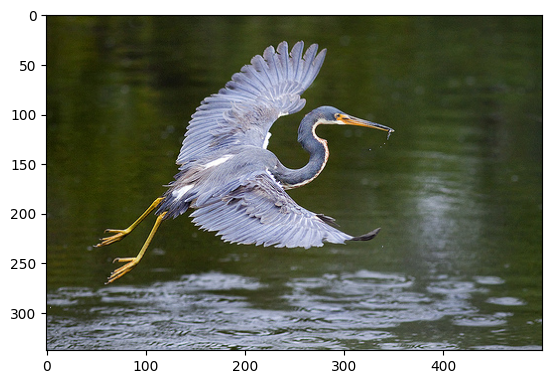

In [398]:
test_model(query_n)

In [399]:
query_n = 50

In [400]:
lemm = lemmatize_query(clear_query(test_query['query_text'].iloc[query_n]))
print(lemm)

a boxer punch a boxer in the face


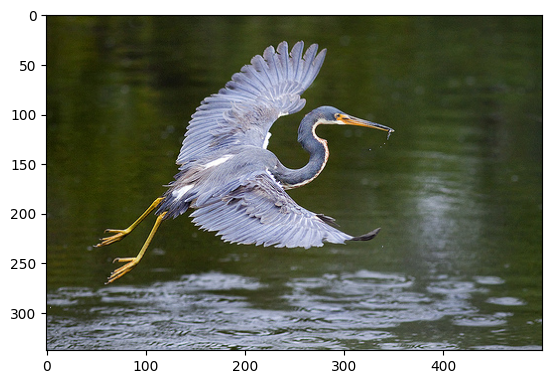

In [401]:
test_model(query_n)

In [402]:
query_n = 90

In [403]:
lemm = lemmatize_query(clear_query(test_query['query_text'].iloc[query_n]))
print(lemm)

A boy play basketball


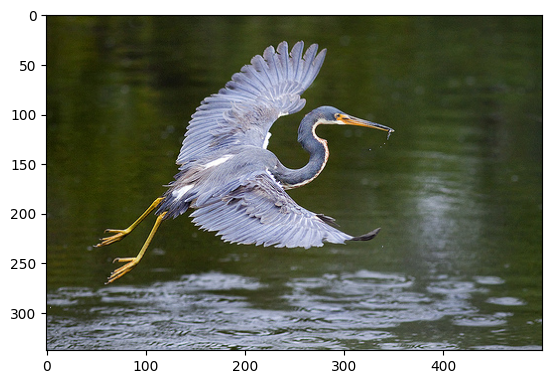

In [404]:
test_model(query_n)

In [240]:
query_n = 0

In [241]:
lemm = lemmatize_query(clear_query(test_query['query_text'].iloc[query_n]))
print(lemm)

Two blonde boys one in a camouflage shirt and the other in blue be have a water fight


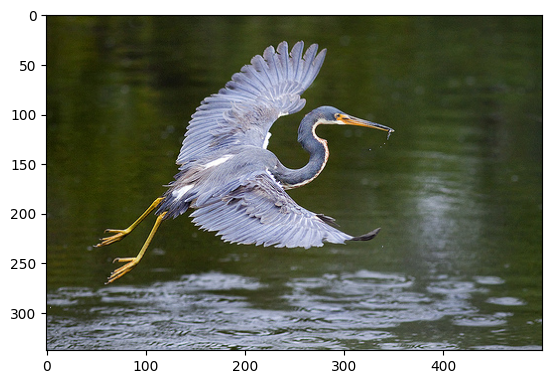

In [242]:
test_model(query_n)

После визуальной оценки качества модели стало понятно, что модель не работает. Модель выдает примерно один и тот же скор для каждой картинки вне зависимости от тестового описания...

## 8. Выводы

- Jupyter Notebook открыт
- Весь код выполняется без ошибок
- Ячейки с кодом расположены в порядке исполнения
- Исследовательский анализ данных выполнен
- Проверены экспертные оценки и краудсорсинговые оценки
- Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- Изображения векторизованы
- Текстовые запросы векторизованы
- Данные корректно разбиты на тренировочную и тестовую выборки
- Предложена метрика качества работы модели
- Предложена модель схожести изображений и текстового запроса
- Модель обучена
- По итогам обучения модели сделаны выводы
- Проведено тестирование работы модели
- По итогам тестирования визуально сравнили качество поиска